#introduction to machine learning
##pca analysis on MNIST dataset

داخل درس با آنالیز مولفه های اصلی آشنا شده اید ، در این تمرین قصد داریم از ابتدا این روش را روی دیتاست داده شده عملی کنیم و نتیایج این روش را با همدیگر مشاهده کنیم.

In [1]:
# Define the personal information
first_name = "Ali"
last_name = "Nikkhah"
student_number = "99102445"

# Create the formatted card
info_card = f'''
╔════════════════════════════╗
║      Personal Info         ║
╠════════════════════════════╣
║ First Name:    {first_name: <12}║
║ Last Name:     {last_name: <12}║
║ Student Number:{student_number: <12}║
╚════════════════════════════╝
'''

# Print the card
print(info_card)



╔════════════════════════════╗
║      Personal Info         ║
╠════════════════════════════╣
║ First Name:    Ali         ║
║ Last Name:     Nikkhah     ║
║ Student Number:99102445    ║
╚════════════════════════════╝



در بخش زیر تمامی کتابخانه هایی که لازم دارید را ایمپورت کنید.

In [2]:
import numpy as np
import pandas as pd

### داده شده را لود کنید MNIST در این قسمت دیتا ست  

پیش از این که مولفه های اصلی داده ها را استخراج کنید آن را نرمالایز کنید.
توجه کنید که سمپل های لود شده به صورت 28*28  میباشند و باید آن را به صورت بردار 784 تایی تبدیل کنید

In [3]:
#load the data set and fill nan value with 0
# TODO (load dataset)
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


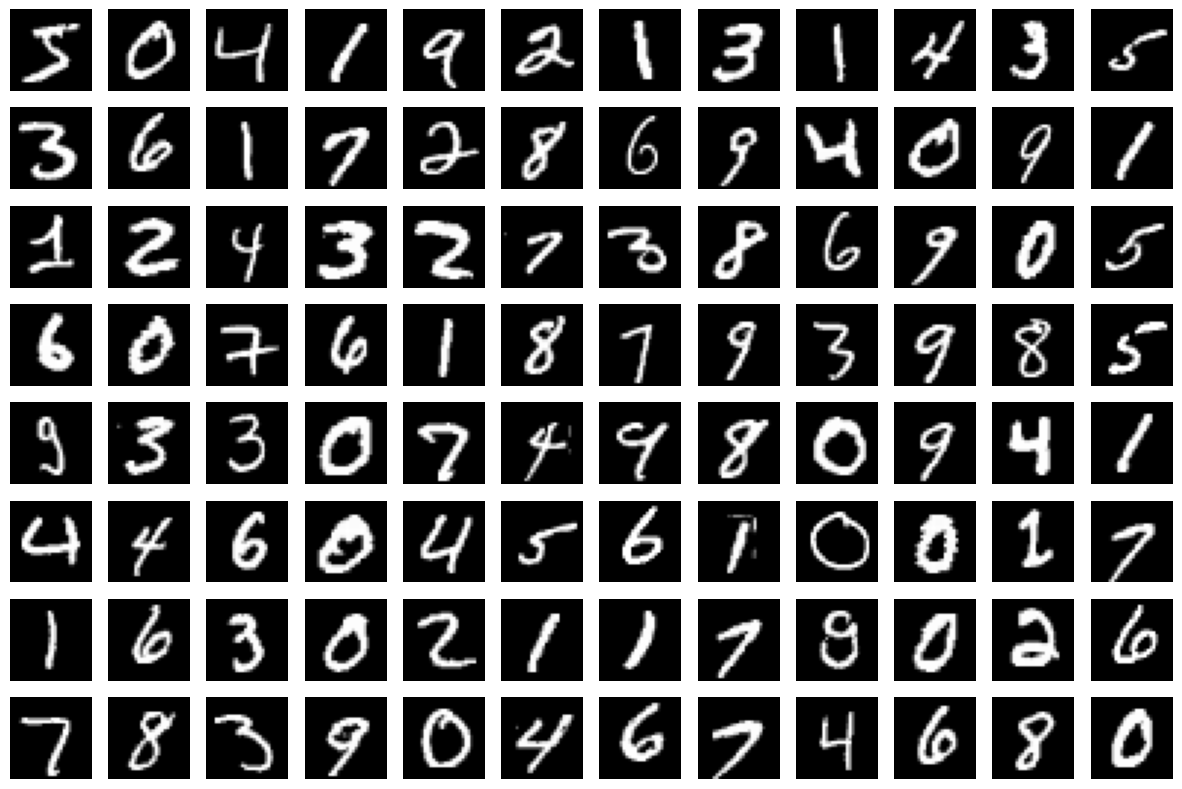

In [4]:
import matplotlib.pyplot as plt
def show_images(X):
    fig, axes = plt.subplots(8, 12, figsize=(15, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X[i], cmap='gray')
        ax.axis('off')
    plt.show()
show_images(x_train)


In [5]:
# Scale the data to the range [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Divide the data by the maximum value (255)
x_train /= 255.0
x_test /= 255.0

در این قسمت ابتدا تابع کواریانس داده را بدست آورید و سپس مقادیر ویژه و بردار ویژه های آن را استخراج کنید.

In [6]:
import numpy as np
from numpy.linalg import eig
num_samples, height, width = x_train.shape
x_train_2d = x_train.reshape(num_samples, height * width)
cov_matrix = np.cov(x_train_2d, rowvar=False)
eigenvalues, eigenvectors = eig(cov_matrix)


در بخش زیر میخواهیم تعدادی از مولفه های اصلی را استخراج کنیم که بخش قابل قبولی از واریانس داده ها را شامل شده باشند.

In [7]:
explained_variance = 0.95 # you can change this variable to get more component of datasets.
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
total_variance = np.sum(sorted_eigenvalues)
explained_variance_threshold = explained_variance * total_variance
cumulative_variance = 0
k = 0
while cumulative_variance < explained_variance_threshold:
    cumulative_variance += sorted_eigenvalues[k]
    k += 1
original_data_size = x_train_2d.shape[1]  # Number of features in the original dataset
reduced_data_size = k  # Number of features in the reduced dataset

print(f"Number of PC to explain {explained_variance } of the variance: {k}")

Number of PC to explain 0.95 of the variance: 154


حال در این بخش دیتاهای موجود را روی این مولفه ها تصویر کنید عملیات کاهش بعدد را انجام دهید و سپس ابعاد را به اندازه تصاویر اصلی برگردانید و  تصویر یکی از سمپل ها را برای هر دو حالت قبل از کاهش بعد روی مولفه ها و بعد از آن رسم کنید.

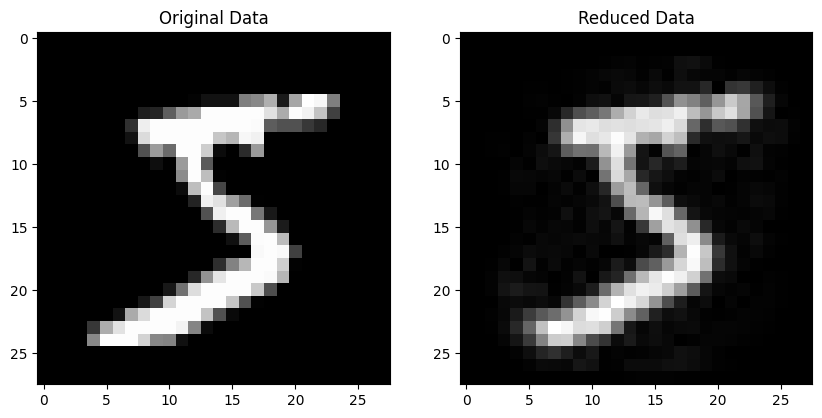

In [14]:
import matplotlib.pyplot as plt
sample = x_train_2d[0]
reduced_sample = np.dot(sample, eigenvectors[:, :k])
reconstructed_sample = np.dot(reduced_sample, eigenvectors[:, :k].T)
sample = sample.reshape(28, 28)
reconstructed_sample = reconstructed_sample.reshape(28, 28)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.imshow(sample, cmap='gray')
magnitude_image = np.abs(reconstructed_sample)
# Display the magnitude image
plt.subplot(1, 2, 2)
plt.title("Reduced Data")
plt.imshow(magnitude_image, cmap='gray')
plt.show()

## Perform PCA and Gauge Max Accuracy

حال میخواهیم برای دیتای تصویر شده یک مدل یادگیری بسازیم و دقت مدل را برحسب تعدا مولفه های اصلی بدست بیاوریم .

In [19]:
import numpy as np

def do_pca(n_components, data):
    '''
    Perform Principal Component Analysis (PCA) on the input data.

    Args:
    n_components (int): Number of principal components to keep.
    data (numpy.ndarray): Input data.

    Returns:
    numpy.ndarray: Projected dataset after PCA.
    '''
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    cov_matrix = np.cov(centered_data, rowvar=False)

    # Ensure that eigenvalues and eigenvectors are real
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    top_eigenvectors = eigenvectors[:, :n_components]
    projected_data = np.dot(centered_data, top_eigenvectors)
    return projected_data


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def ML_model(X_train,X_test,y_train,y_test, print_output=True):
    '''
    Evaluate the accuracy of a machine learning model on the input dataset and labels.

    Args:
    X (numpy.ndarray): Input dataset.
    y (numpy.ndarray): Labels.
    print_output (bool): Whether to print the accuracy (default is True).

    Returns:
    float: Accuracy of the model on the dataset.
    '''

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier()
    print(X_train.shape)
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    if print_output:
        print(f"Accuracy: {accuracy:.2f}")

    return accuracy


In [21]:
num_samples, height, width = x_train.shape
x_train_reshaped = x_train.reshape(num_samples, height * width)
num_samples, height, width = x_test.shape
x_test_reshaped = x_test.reshape(num_samples,height*width)

(60000, 784)


Running PCA and Decision Tree: 100%|██████████| 28/28 [02:21<00:00,  5.06s/it]


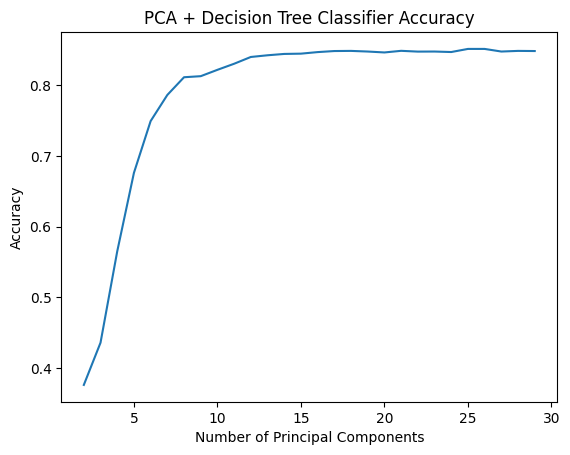

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

print(x_train_reshaped.shape)

acc_list = []
pc_list = []

# Wrap the loop with tqdm to show a progress bar
for m in tqdm(range(2, 30), desc="Running PCA and Decision Tree"):
    # Initialize a PCA object with the current number of components
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(x_train_reshaped.reshape(x_train_reshaped.shape[0], -1))

    # Create and train a Decision Tree Classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train_pca, y_train)

    # Transform the testing data using the same PCA object
    X_test_pca = pca.transform(x_test_reshaped.reshape(x_test_reshaped.shape[0], -1))

    # Evaluate the model
    accuracy = clf.score(X_test_pca, y_test)

    acc_list.append(accuracy)
    pc_list.append(m)

    
# Plot the results
plt.plot(pc_list, acc_list)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('PCA + Decision Tree Classifier Accuracy')
plt.show()


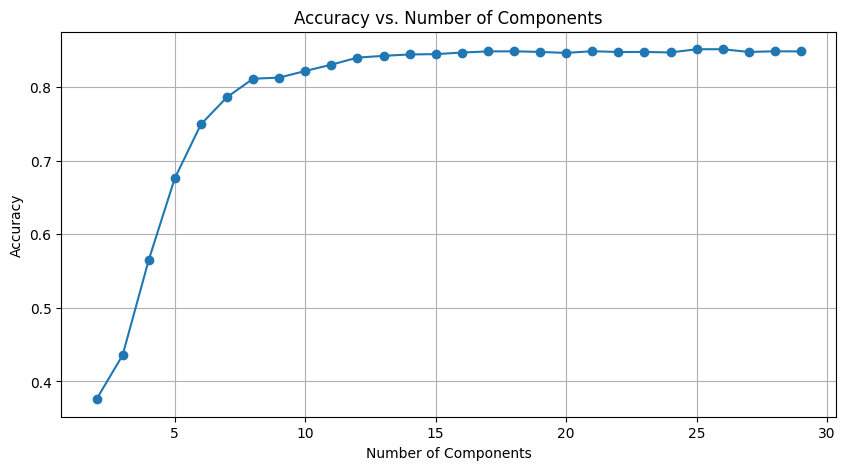

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pc_list, acc_list, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [33]:
max_accuracy = max(acc_list)
optimal_components = pc_list[acc_list.index(max_accuracy)]

print(f"Number of Components that Maximize Accuracy: {optimal_components}")
print(f"Maximum Accuracy: {max_accuracy:.2f}")

Number of Components that Maximize Accuracy: 25
Maximum Accuracy: 0.85


In [28]:
# Specify the file path to your dataset
file_path = '/kaggle/input/diabets/diabetes.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract features (X) and target variable (Y)
X = df.iloc[:, :7]  # Select columns from the first until num_column-1
Y = df.iloc[:, -1]  # Select the last column as the target variable

# Display the shape of X and Y to verify the extraction
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (768, 7)
Shape of Y: (768,)


In [ ]:
def ML_model(X_train,X_test,y_train,y_test, print_output=True):
    '''
    Evaluate the accuracy of a machine learning model on the input dataset and labels.

    Args:
    X (numpy.ndarray): Input dataset.
    y (numpy.ndarray): Labels.
    print_output (bool): Whether to print the accuracy (default is True).

    Returns:
    float: Accuracy of the model on the dataset.
    '''

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier()
    print(X.shape)
    clf.fit(X, Y)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    if print_output:
        print(f"Accuracy: {accuracy:.2f}")

    return accuracy


In [29]:
pca = PCA(n_components=m)

clf = DecisionTreeClassifier()
clf.fit(X, Y)

# Evaluate the model
accuracy = clf.score(X, Y)
print('accuracy on Diabets dataset:',accuracy)

accuracy on Diabets dataset: 1.0
